<a href="https://colab.research.google.com/github/AyazNakhudaGitHub/BERT_Customer_Reviews_Classification/blob/main/5_category_summarized_text_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Summarized Text, 5 Categories**

In this experiement we utilize the summarized versions of the reivew texts and classiy them into 5 categories.

In [ ]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
     |████████████████████████████████| 213 kB 60.4 MB/s 
     |████████████████████████████████| 352 kB 54.4 MB/s 
     |████████████████████████████████| 1.2 MB 33.4 MB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 35.2 MB/s 
     |████████████████████████████████| 99 kB 8.5 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 


In [ ]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [ ]:
import os
import urllib, json

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from tensorflow.keras.utils import to_categorical

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11257937342300915826
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15580148520975577967
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading in the pre-trained model:

In [ ]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
data_2 = pd.read_pickle('/content/drive/MyDrive/V13.plk')

In [ ]:
data_2.head(500)

reviewerID        asin  ... unixReviewTime   reviewTime
7     A1ZH5ULI4SBO48  0615391206  ...     1323302400   12 8, 2011
13    A14BTJRH9VNLJJ  0689027818  ...     1365206400   04 6, 2013
15    A2WNXS3CNAQS01  0689027818  ...     1082592000  04 22, 2004
23     A33T8O72UNBVR  0912696591  ...     1370649600   06 8, 2013
26    A2X4WC4ZRM0WTA  0912696591  ...     1343779200   08 1, 2012
...              ...         ...  ...            ...          ...
1413  A2Y0438USHFBCM  B00002ND6A  ...     1310256000  07 10, 2011
1414   ABEER2IPB7HU2  B00002ND6A  ...     1285632000  09 28, 2010
1416  A3JERSPQZ0Z97H  B00002ND6A  ...     1215734400  07 11, 2008
1419  A2R8Z9CEGYX31N  B00004OCIP  ...     1200182400  01 13, 2008
1424  A1OBJYK6JH67AF  B00004OCIP  ...     1398556800  04 27, 2014

[500 rows x 9 columns]

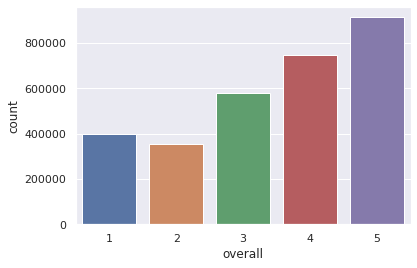

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=data_2)

In [ ]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991159 entries, 7 to 7591158
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   reviewerID      object
 1   asin            object
 2   reviewerName    object
 3   helpful         object
 4   reviewText      object
 5   overall         int64 
 6   summary         object
 7   unixReviewTime  int64 
 8   reviewTime      object
dtypes: int64(2), object(7)
memory usage: 228.2+ MB


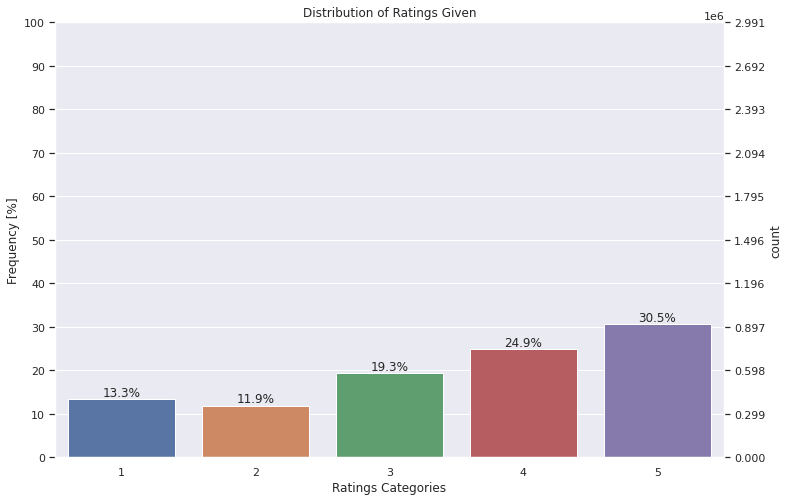

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
ax = sns.countplot(x="overall", data=data_2, order=[1,2,3,4,5])
plt.title('Distribution of Ratings Given')
plt.xlabel('Ratings Categories')
ncount = len(data_2)
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

In [ ]:
# getting the 1's 
np.random.seed(10)
get_n = 6490
index_to_get = data_2[data_2.overall == 1].index
get_indices_a = np.random.choice(index_to_get, get_n, replace=False)
data_a = data_2.loc[get_indices_a]


# getting the 2's
np.random.seed(10)
get_n = 7930
index_to_get = data_2[data_2.overall == 2].index
get_indices_b = np.random.choice(index_to_get, get_n, replace=False)
data_b = data_2.loc[get_indices_b]

# getting the 3's
np.random.seed(10)
get_n = 7720
index_to_get = data_2[data_2.overall == 3].index
get_indices_c = np.random.choice(index_to_get, get_n, replace=False)
data_c = data_2.loc[get_indices_c]

# getting the 4's
np.random.seed(10)
get_n = 9960
index_to_get = data_2[data_2.overall == 4].index
get_indices_d = np.random.choice(index_to_get, get_n, replace=False)
data_d = data_2.loc[get_indices_d]

# getting the 5's
np.random.seed(10)
get_n = 11200
index_to_get = data_2[data_2.overall == 5].index
get_indices_e = np.random.choice(index_to_get, get_n, replace=False)
data_e = data_2.loc[get_indices_e]

In [ ]:
drop_indicies = np.concatenate((get_indices_a,get_indices_b,get_indices_c),axis=0)
data_2 = data_2.drop(drop_indicies, axis=0)

In [ ]:
new_data = pd.concat([data_a, data_b, data_c,data_d,data_e])

In [ ]:
new_data=new_data.drop('asin',axis=1)
new_data=new_data.drop('reviewerName',axis=1)
new_data=new_data.drop('unixReviewTime',axis=1)
new_data=new_data.drop('reviewTime',axis=1)

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43300 entries, 6363187 to 4860022
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewerID  43300 non-null  object
 1   helpful     43300 non-null  object
 2   reviewText  43300 non-null  object
 3   overall     43300 non-null  int64 
 4   summary     43300 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [ ]:
import sklearn


x = new_data.summary.values
y = new_data.overall.values

def data_split(examples, labels, train_frac = 0.8, random_state=None):


    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    X_train, X_tmp, Y_train, Y_tmp = sklearn.model_selection.train_test_split(
                                        examples, labels, train_size=train_frac, random_state=random_state)

    X_val, X_test, Y_val, Y_test   = sklearn.model_selection.train_test_split(
                                        X_tmp, Y_tmp, train_size=0.5, random_state=random_state)

    return X_train, X_val, X_test,  Y_train, Y_val, Y_test

x_train, x_val, x_test,  y_train, y_val, y_test = data_split(x,y,0.8,23)

In [ ]:
print(x_train.shape)

(34640,)


In [ ]:
encoder = LabelEncoder()
encoder.fit(y)

encoded_Y_train = encoder.transform(y_train)
encoded_Y_val = encoder.transform(y_val)
encoded_Y_test = encoder.transform(y_test)


# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)
dummy_y_val = to_categorical(encoded_Y_val)
dummy_y_train = to_categorical(encoded_Y_train)

In [ ]:

def encode_names(n):
   tokens = list(tokenizer.tokenize(n)[:24]+tokenizer.tokenize(n)[-59:])
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

reviews = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized reviews shape', reviews.shape.as_list())

Tokenized reviews shape [34640, None]


In [ ]:
x_train[0]

'a honest review'

In [ ]:

cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)
#_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

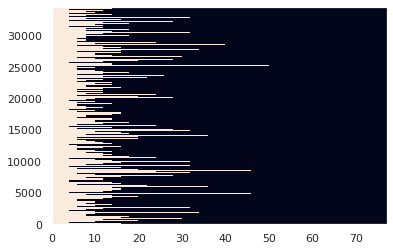

In [ ]:

input_mask = tf.ones_like(input_word_ids).to_tensor()
plt.pcolormesh(input_mask)

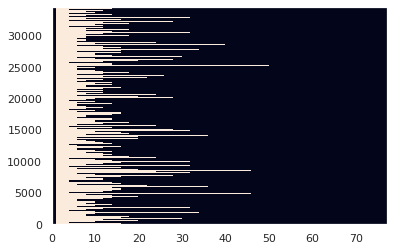

In [ ]:

type_cls = tf.zeros_like(cls)
type_review = tf.ones_like(reviews)
input_type_ids = tf.concat([type_cls, type_review], axis=-1).to_tensor()
plt.pcolormesh(input_type_ids)

In [ ]:
lens = [len(i) for i in input_word_ids]
#max_seq_length = max(lens)
#print('Max length is:', max_seq_length)

In [ ]:
#max_seq_length = int(1.5*max_seq_length)
#print('Max length is:', max_seq_length)

In [ ]:
#max_seq_length = max(lens)
#print('Max length is:', max_seq_length)

In [ ]:

def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n)[:24]+tokenizer.tokenize(n)[-59:])
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))



  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
max_seq_length = 85


In [ ]:

X_train = bert_encode(x_train, tokenizer, max_seq_length)    
X_val = bert_encode(x_val, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [ ]:
epochs = 6
batch_size = 8 
eval_batch_size = batch_size
LR = 2e-6

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

In [ ]:

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                 


pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids]) 
flatten = tf.keras.layers.Flatten(name='flatten')
output_flatten = flatten(pooled_output)                                 
output = tf.keras.layers.Dropout(rate=0.1)(output_flatten) 
output = tf.keras.layers.Dense(512, kernel_regularizer= tf.keras.regularizers.L2(0.01), activity_regularizer= tf.keras.regularizers.L1(0.01),activation='relu')(output)
output = tf.keras.layers.Dense(5, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)


In [ ]:
pooled_output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
import tensorflow_addons as tfa

In [ ]:
model.compile(tfa.optimizers.RectifiedAdam(learning_rate=LR, beta_1= 0.8, beta_2=0.8), # try sgd  
              loss='categorical_crossentropy',
              metrics=['accuracy'],
  
              )

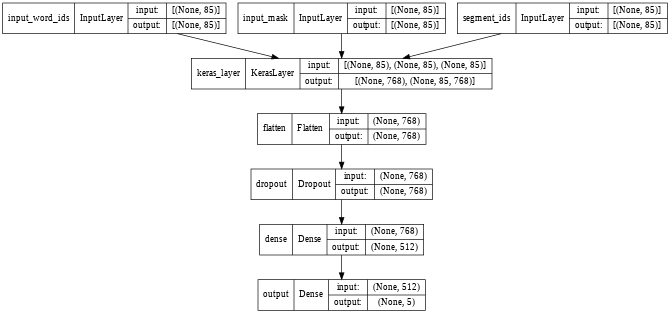

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 85)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 85)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 85, 768)]                 'input_mask[0][0]',         

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, dummy_y_val),
                    verbose=1)

Epoch 1/6
4330/4330 [==============================] - 646s 143ms/step - loss: 7.1251 - accuracy: 0.3616 - val_loss: 6.2337 - val_accuracy: 0.4515
Epoch 2/6
4330/4330 [==============================] - 616s 142ms/step - loss: 5.5986 - accuracy: 0.4725 - val_loss: 4.9847 - val_accuracy: 0.4947
Epoch 3/6
4330/4330 [==============================] - 613s 142ms/step - loss: 4.4751 - accuracy: 0.5009 - val_loss: 4.0068 - val_accuracy: 0.5037
Epoch 4/6
4330/4330 [==============================] - 613s 142ms/step - loss: 3.5831 - accuracy: 0.5259 - val_loss: 3.2549 - val_accuracy: 0.5106
Epoch 5/6
4330/4330 [==============================] - 613s 142ms/step - loss: 2.9147 - accuracy: 0.5463 - val_loss: 2.7237 - val_accuracy: 0.5182
Epoch 6/6
4330/4330 [==============================] - 615s 142ms/step - loss: 2.4422 - accuracy: 0.5668 - val_loss: 2.3765 - val_accuracy: 0.5157


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

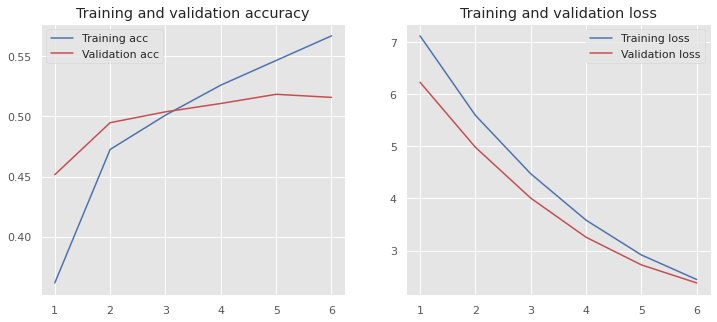

In [ ]:
plot_history(history)

In [ ]:
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.4949


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test, batch_size=1, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1) + 1
print(classification_report(y_test, y_pred_bool, labels=[1,2,3,4,5], digits=4))



4330/4330 [==============================] - 43s 10ms/step
              precision    recall  f1-score   support

           1     0.5402    0.5378    0.5390       649
           2     0.3995    0.4655    0.4300       739
           3     0.4403    0.3577    0.3947       794
           4     0.4608    0.4585    0.4597      1025
           5     0.6010    0.6198    0.6103      1123

    accuracy                         0.4949      4330
   macro avg     0.4884    0.4878    0.4867      4330
weighted avg     0.4949    0.4949    0.4936      4330



In [ ]:
model_fname = 'BERT_5cat_short'
my_wd = '/content/drive/My Drive'

model.save(model_fname)

INFO:tensorflow:Assets written to: BERT_5cat_short/assets


INFO:tensorflow:Assets written to: BERT_5cat_short/assets


In the next part of this notebook, we utilized T-SNE to visualize our data using 5 categories.

In [ ]:
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer('flatten').output)

In [ ]:
sentence_embedded = intermediate_layer_model.predict(X_train)

In [ ]:
labels_rating = new_data.overall

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X = list(sentence_embedded)

X_embedded = TSNE(n_components=2).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=y_train)

In [ ]:
df_embeddings = df_embeddings.assign(text=x_train)

In [ ]:
import plotly.express as px

fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'},
    hover_data=['text'], title = 'Overall Ratings Embedding Visualization')
fig.show()

In [ ]:
df_embeddings['length_text'] = df_embeddings[['text']].applymap(lambda x : len(x))

In [ ]:
fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'},
    size = 'length_text', size_max = 10, template = 'simple_white',
    hover_data=['text'], title = 'Overall Ratings Embedding Visualization')
fig.show()